Please run those two cells before running the Notebook!

As those plotting settings are standard throughout the book, we do not show them in the book every time we plot something.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

# feel free to modify, for example, change the context to "notebook"
sns.set_theme(context="talk", style="whitegrid", 
              palette="colorblind", color_codes=True, 
              rc={"figure.figsize": [12, 8]})

# Chapter 9 - Modeling Volatility with GARCH class models

## 9.1 Modeling stock returns' volatility with ARCH models

### How to do it...

1. Import the libraries:

In [3]:
import pandas as pd
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [4]:
RISKY_ASSET = "GOOG"
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [5]:
df = yf.download(RISKY_ASSET,
                 start=START_DATE,
                 end=END_DATE)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%%**********************]  1 of 1 completed

Downloaded 1762 rows of data.


In [6]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641
...,...,...,...,...,...,...
2021-12-23,147.089493,148.572601,146.950851,147.142502,147.142502,13818000
2021-12-27,147.463501,148.426498,147.250000,148.063995,148.063995,13256000
2021-12-28,148.374496,148.374496,145.935501,146.447998,146.447998,18624000


4. Calculate daily returns:

Average return: 0.11%


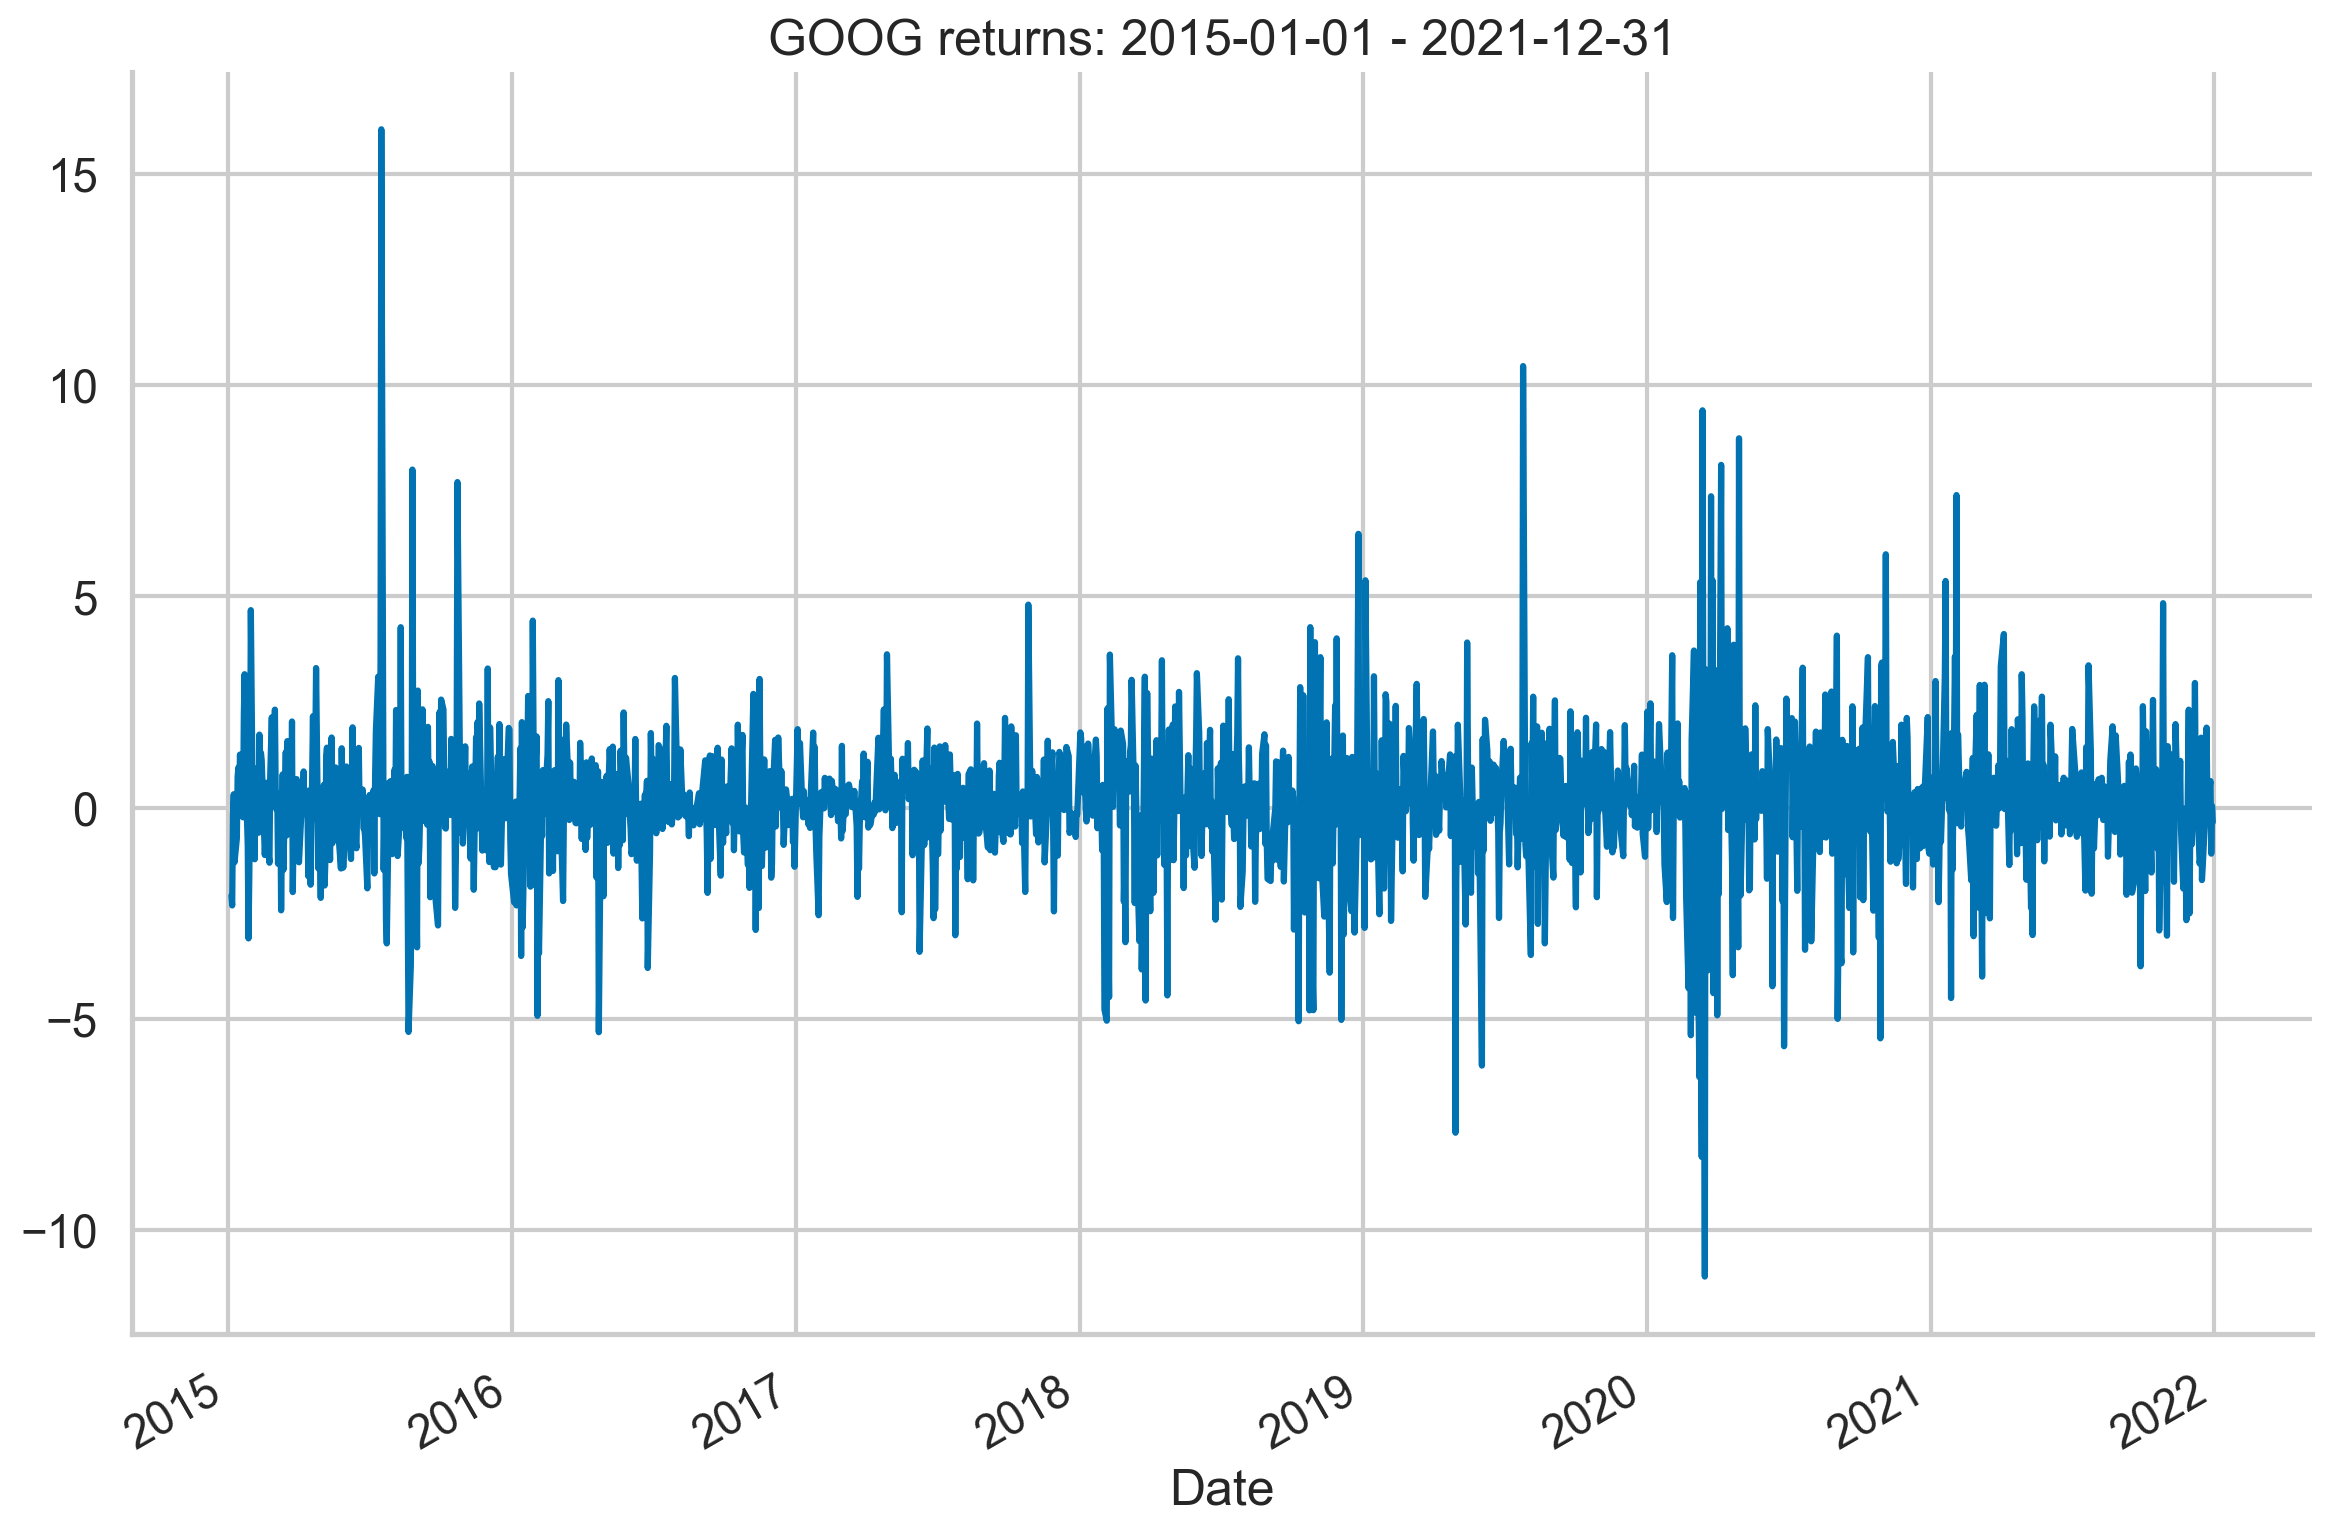

In [7]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"
print(f"Average return: {round(returns.mean(), 2)}%")
returns.plot(title=f"{RISKY_ASSET} returns: {START_DATE} - {END_DATE}");

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_1", dpi=200)

5. Specify the ARCH model:

In [8]:
model = arch_model(returns, mean="Zero", vol="ARCH", p=1, q=0)

6. Estimate the model and print the summary:

In [9]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                        Zero Mean - ARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                       ARCH   Log-Likelihood:               -3301.32
Distribution:                  Normal   AIC:                           6606.64
Method:            Maximum Likelihood   BIC:                           6617.59
                                        No. Observations:                 1761
Date:                Wed, Feb 28 2024   Df Residuals:                     1761
Time:                        12:06:16   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          1.8608      0.166     11.207  3.786e-29 [  1.535,  2.18

7. Plot the residuals and the conditional volatility:

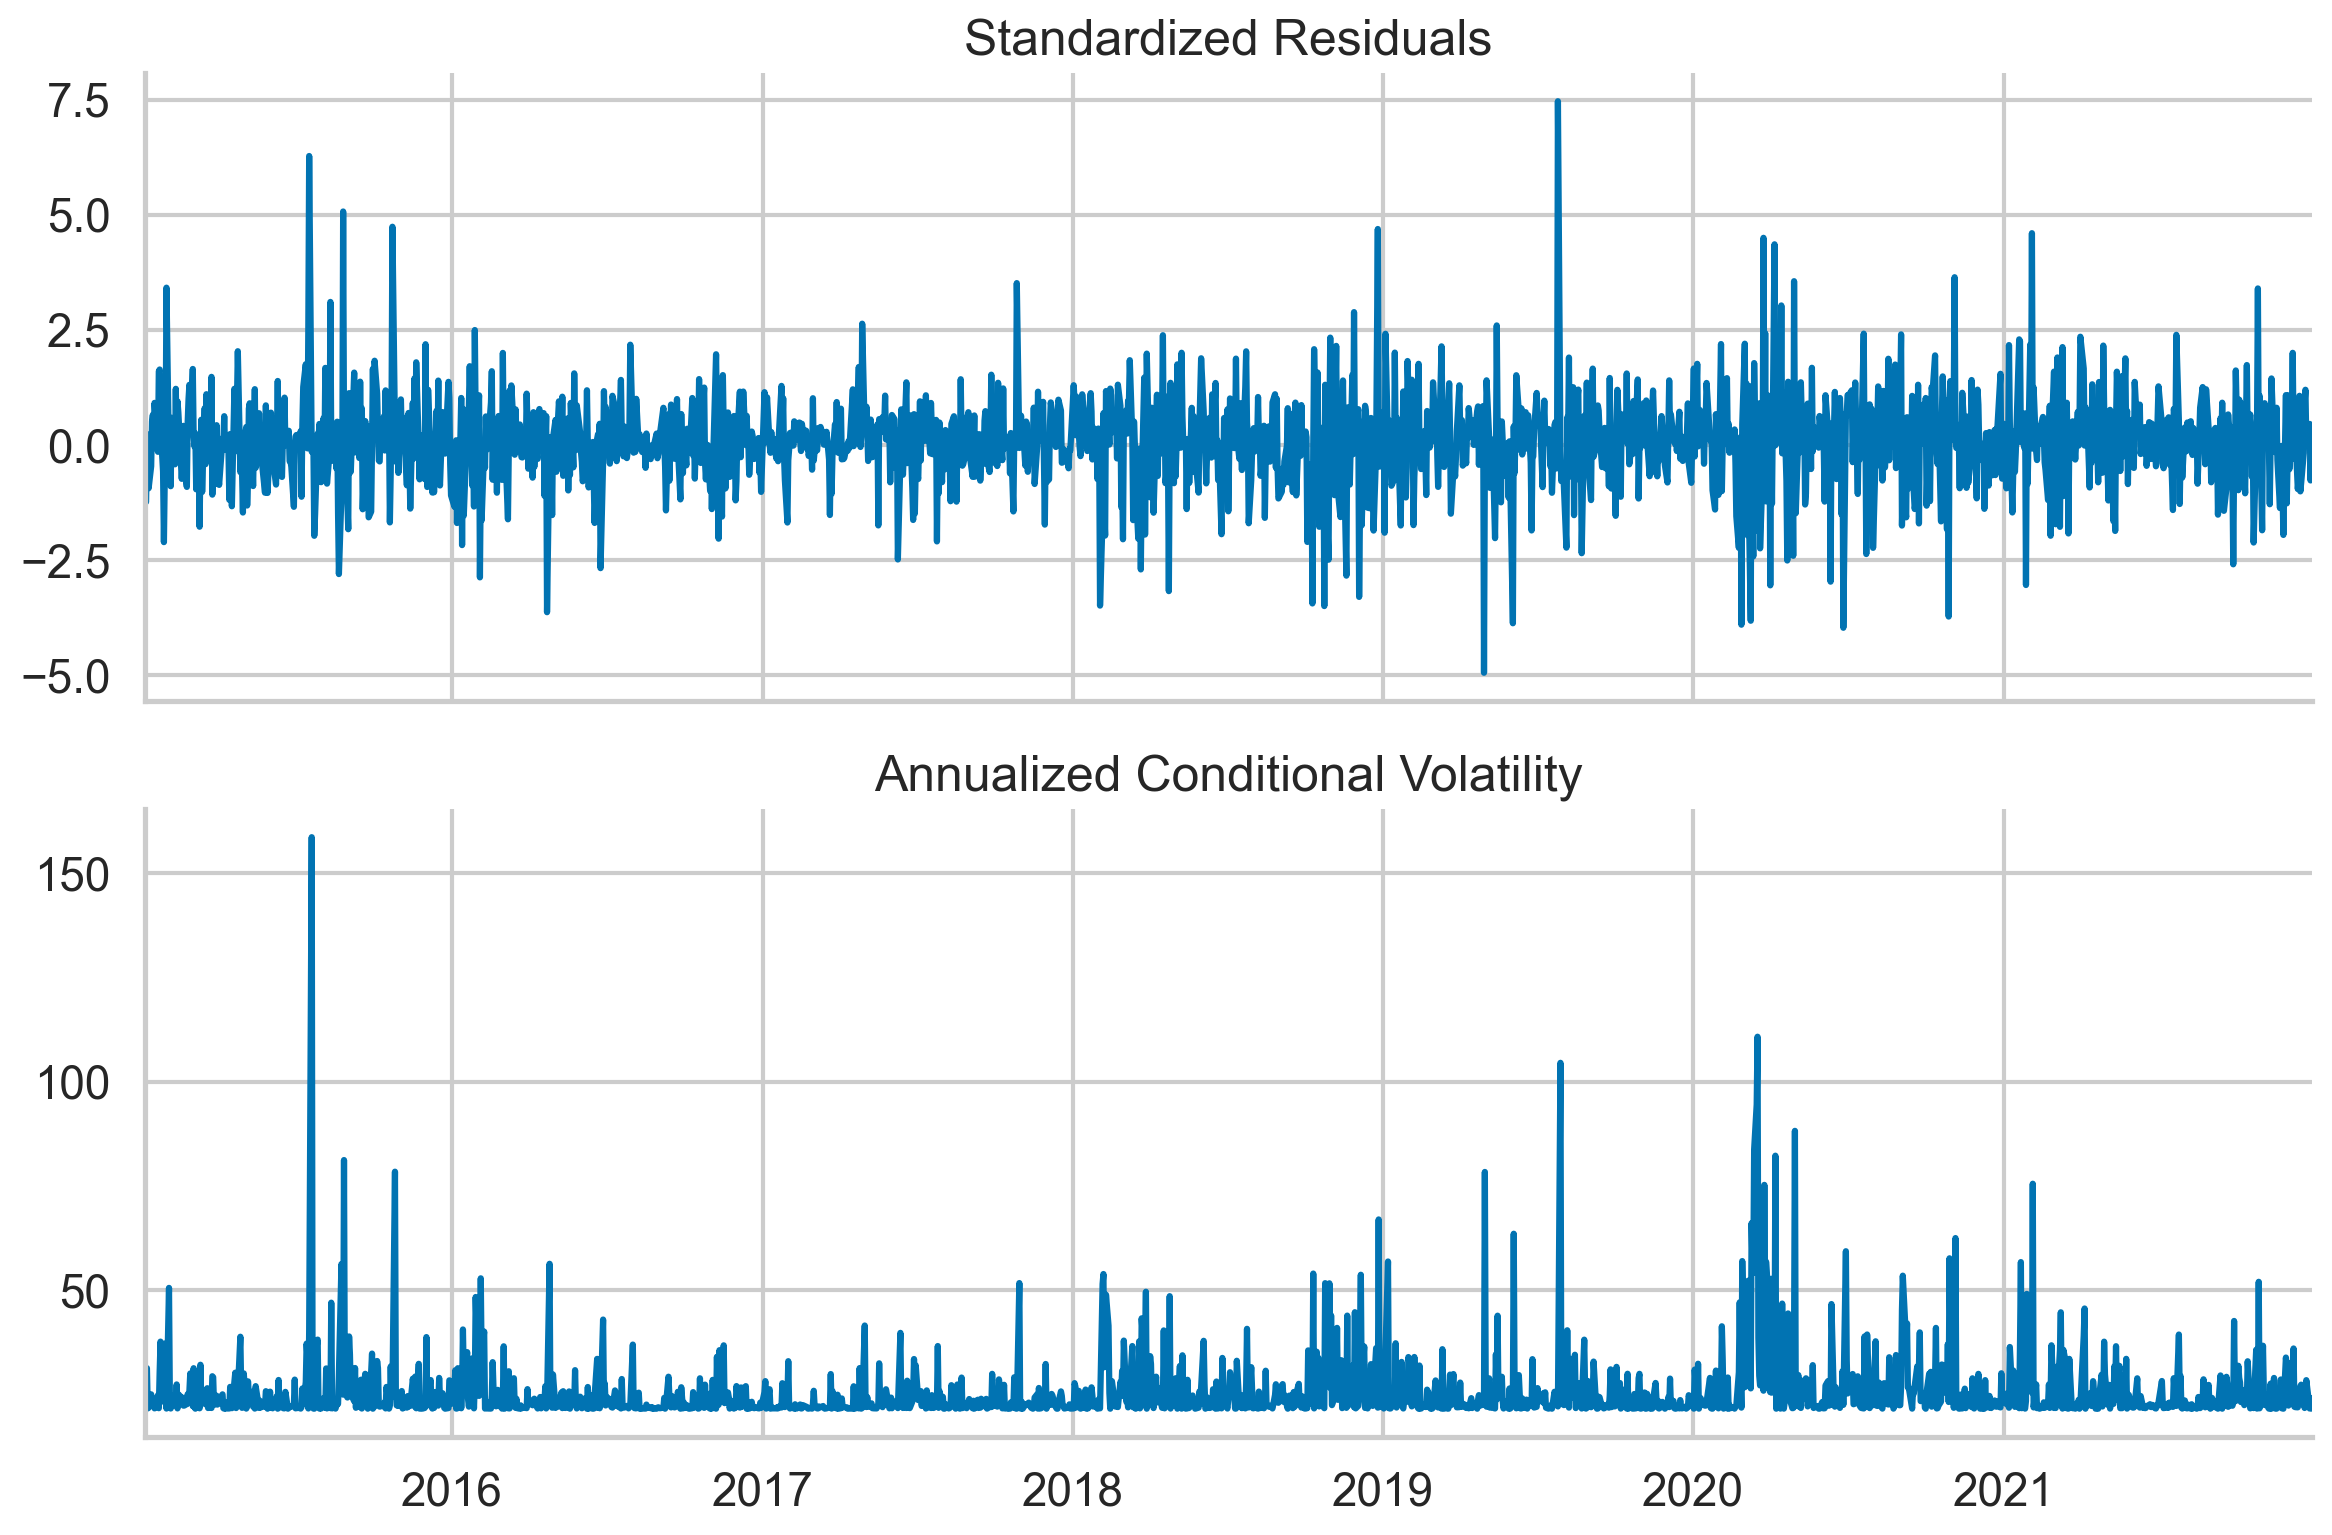

In [10]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_2", dpi=200)

In the cell below we confirm that the standardized residuals are simply residuals divided by the conditional volatility.

In [11]:
diagnostics_dict = {
    "resids": fitted_model.resid,
    "conditional_volatility": fitted_model.conditional_volatility,
    "std_resid": fitted_model.std_resid,
    "std_resid_manual": fitted_model.resid / fitted_model.conditional_volatility,
}

df_diagnostics = pd.DataFrame(data = diagnostics_dict)
df_diagnostics

,resids,conditional_volatility,std_resid,std_resid_manual
Date,,,,
2015-01-05,-2.084562,1.661243,-1.254820,-1.254820
2015-01-06,-2.317709,1.874595,-1.236379,-1.236379
2015-01-07,-0.171323,1.976012,-0.086702,-0.086702
2015-01-08,0.315304,1.368190,0.230453,0.230453
2015-01-09,-1.295055,1.377898,-0.939877,-0.939877
...,...,...,...,...
2021-12-23,0.131676,1.795163,0.073350,0.073350
2021-12-27,0.626259,1.366519,0.458288,0.458288
2021-12-28,-1.091418,1.417745,-0.769827,-0.769827


### There's more

Test the residuals of the ARCH(1) model with the LM test.

In [12]:
from statsmodels.stats.diagnostic import het_arch
het_arch(fitted_model.resid)

(98.0392333043721,
 1.3442180956394036e-16,
 10.320164240233241,
 4.355500142484824e-17)

As the residuals come from a model in which we estimated two parameters (omega and alpha), we should correct for that when using the `het_arch` test.

In [13]:
het_arch(fitted_model.resid, ddof=2)

(97.92725245536653,
 1.415281607860169e-16,
 10.320164240233241,
 4.355500142484824e-17)

## 9.2 Modeling stock returns' volatility with GARCH models

### How to do it...

1. Specify the GARCH model:

In [14]:
model = arch_model(returns, mean="Zero", vol="GARCH", p=1, q=1)

2. Estimate the model and print the summary:

In [15]:
fitted_model = model.fit(disp="off")
print(fitted_model.summary())

                       Zero Mean - GARCH Model Results                        
Dep. Variable:          asset_returns   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -3245.30
Distribution:                  Normal   AIC:                           6496.61
Method:            Maximum Likelihood   BIC:                           6513.03
                                        No. Observations:                 1761
Date:                Wed, Feb 28 2024   Df Residuals:                     1761
Time:                        12:06:18   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.2878      0.187      1.540      0.123 [-7.83

3. Plot the residuals and the conditional volatility:

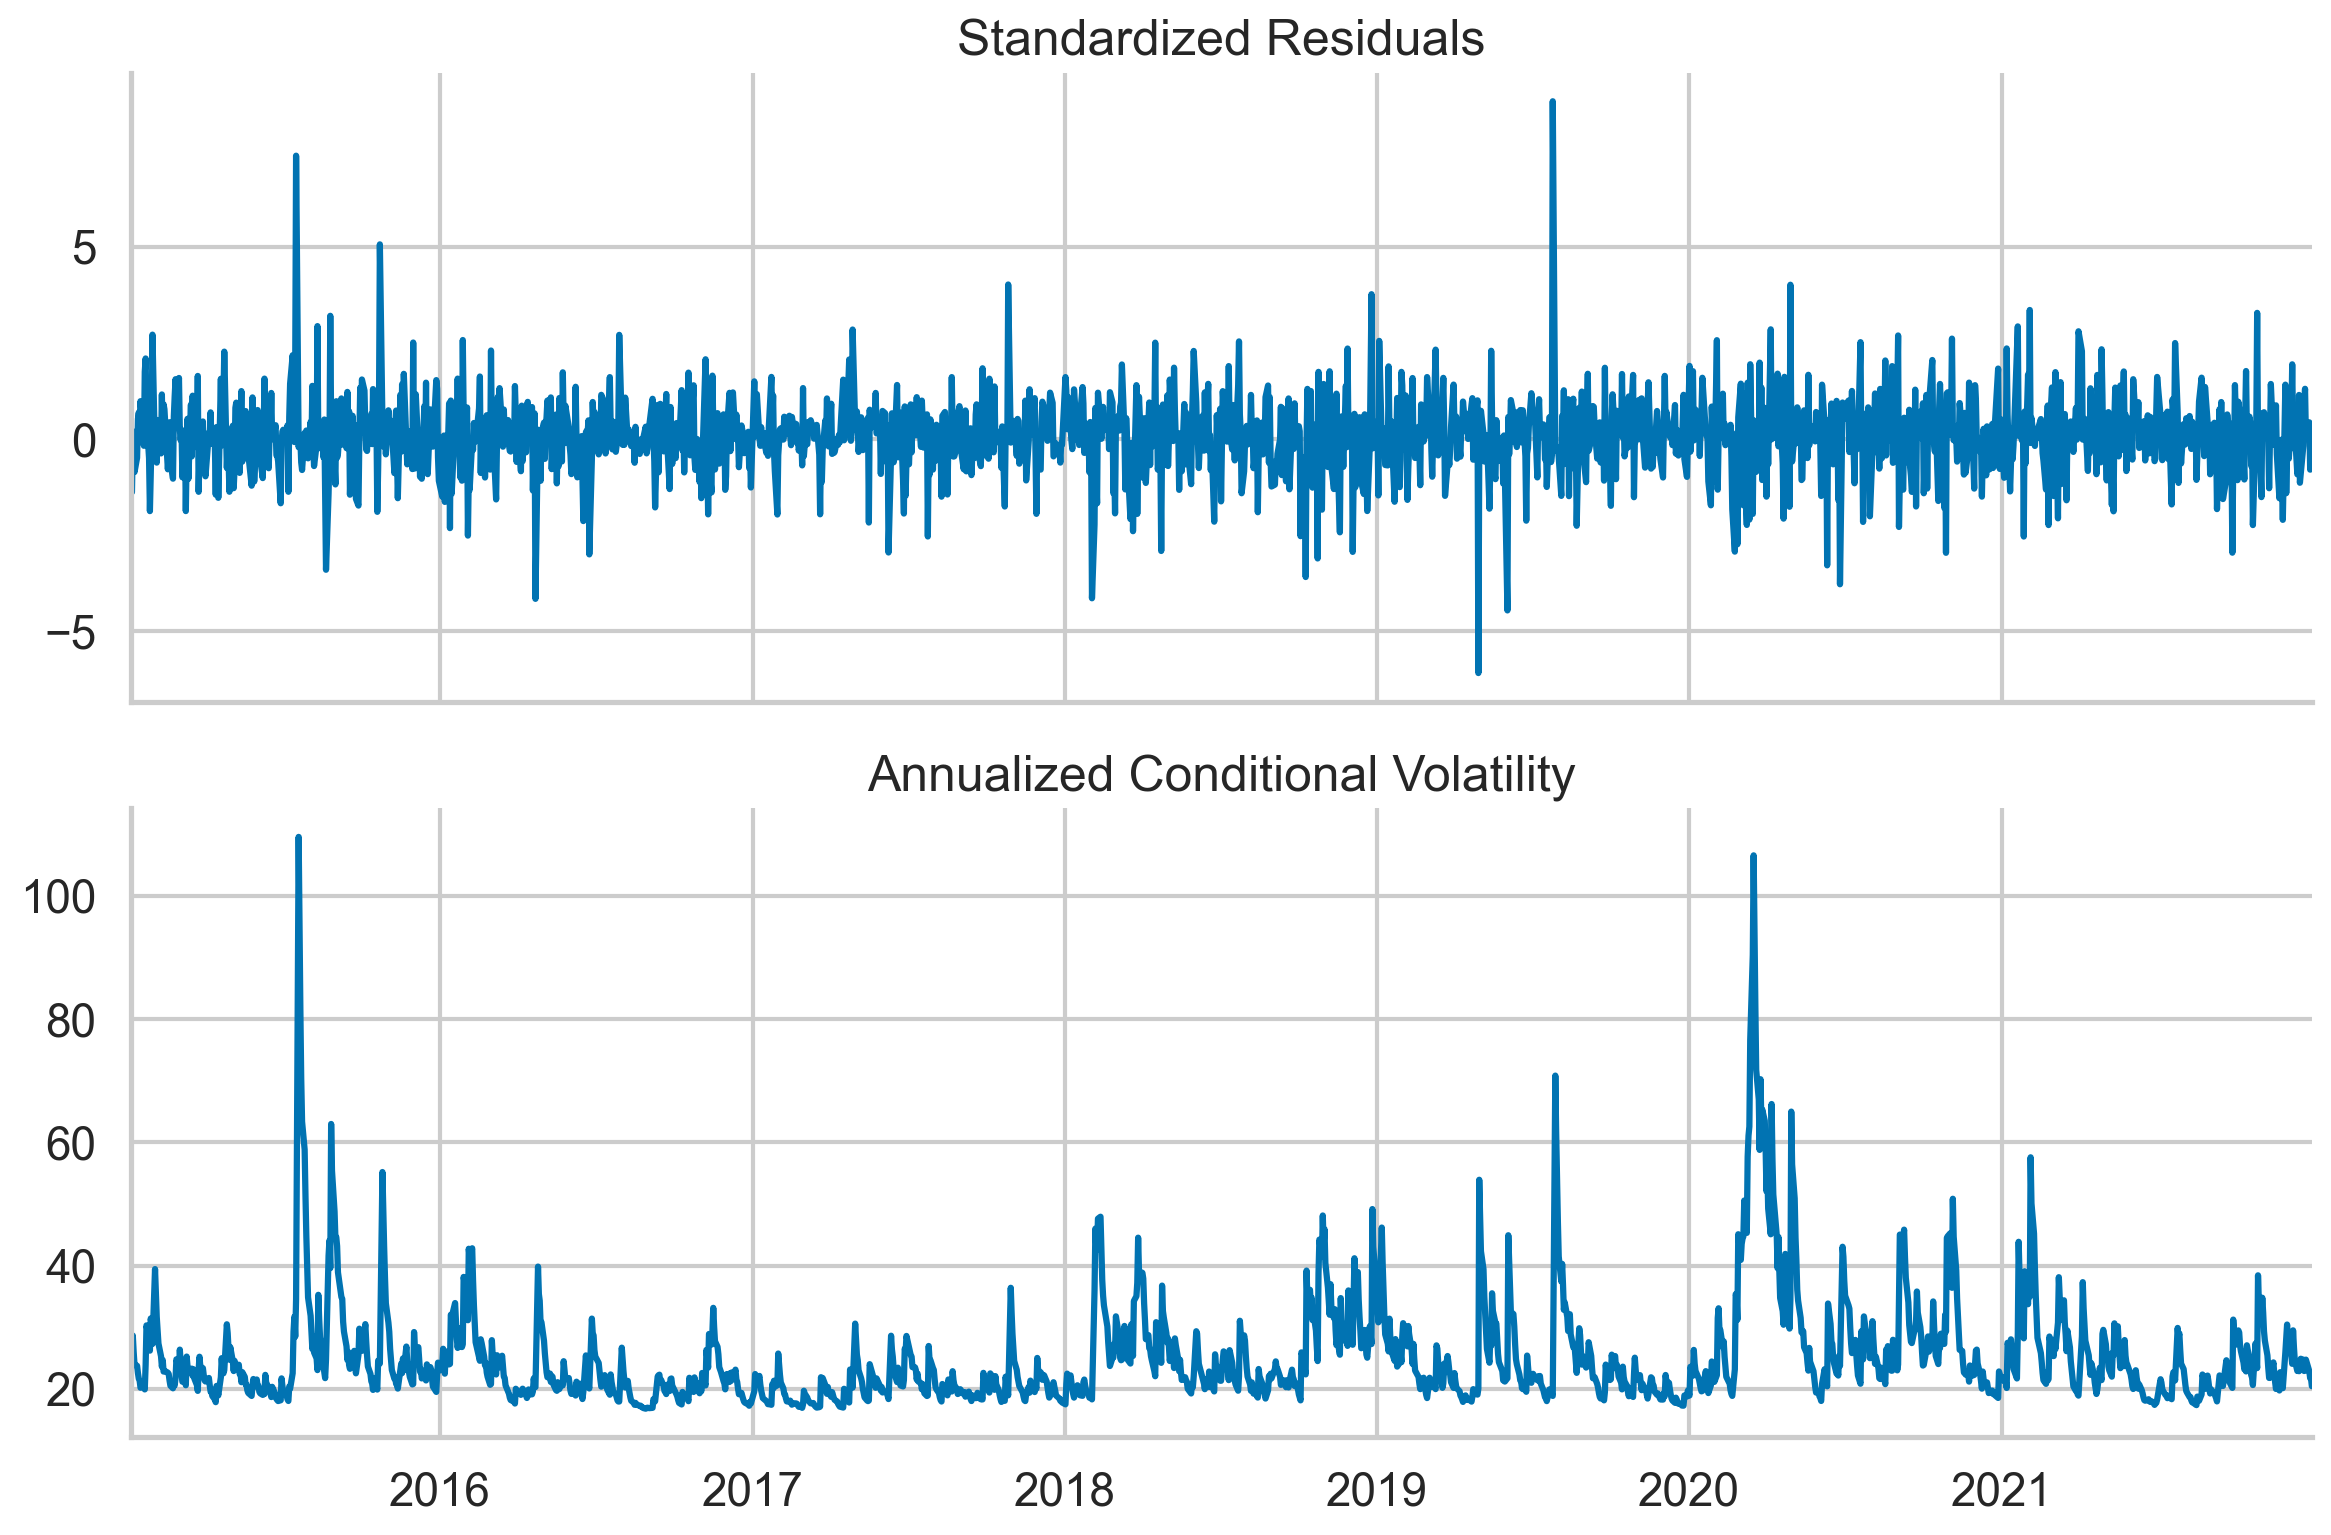

In [16]:
fitted_model.plot(annualize="D")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_3", dpi=200)

## 9.3 Forecasting volatility using GARCH models

### How to do it...

1. Import the libraries:

In [17]:
import pandas as pd
import yfinance as yf
from datetime import datetime
from arch import arch_model

2. Download data from Yahoo Finance and calculate simple returns:

In [18]:
df = yf.download("MSFT",
                 start="2015-01-01",
                 end="2021-12-31")

returns = 100 * df["Adj Close"].pct_change().dropna()
returns.name = "asset_returns"

[*********************100%%**********************]  1 of 1 completed


3. Specify the GARCH model:

In [19]:
model = arch_model(returns, mean="Zero", vol="GARCH", dist="t",
                   p=1, q=1)

4. Define the split date and fit the model:

In [20]:
SPLIT_DATE = datetime(2021, 1, 1)
fitted_model = model.fit(last_obs=SPLIT_DATE, disp="off")

5. Create and inspect the analytical forecasts:

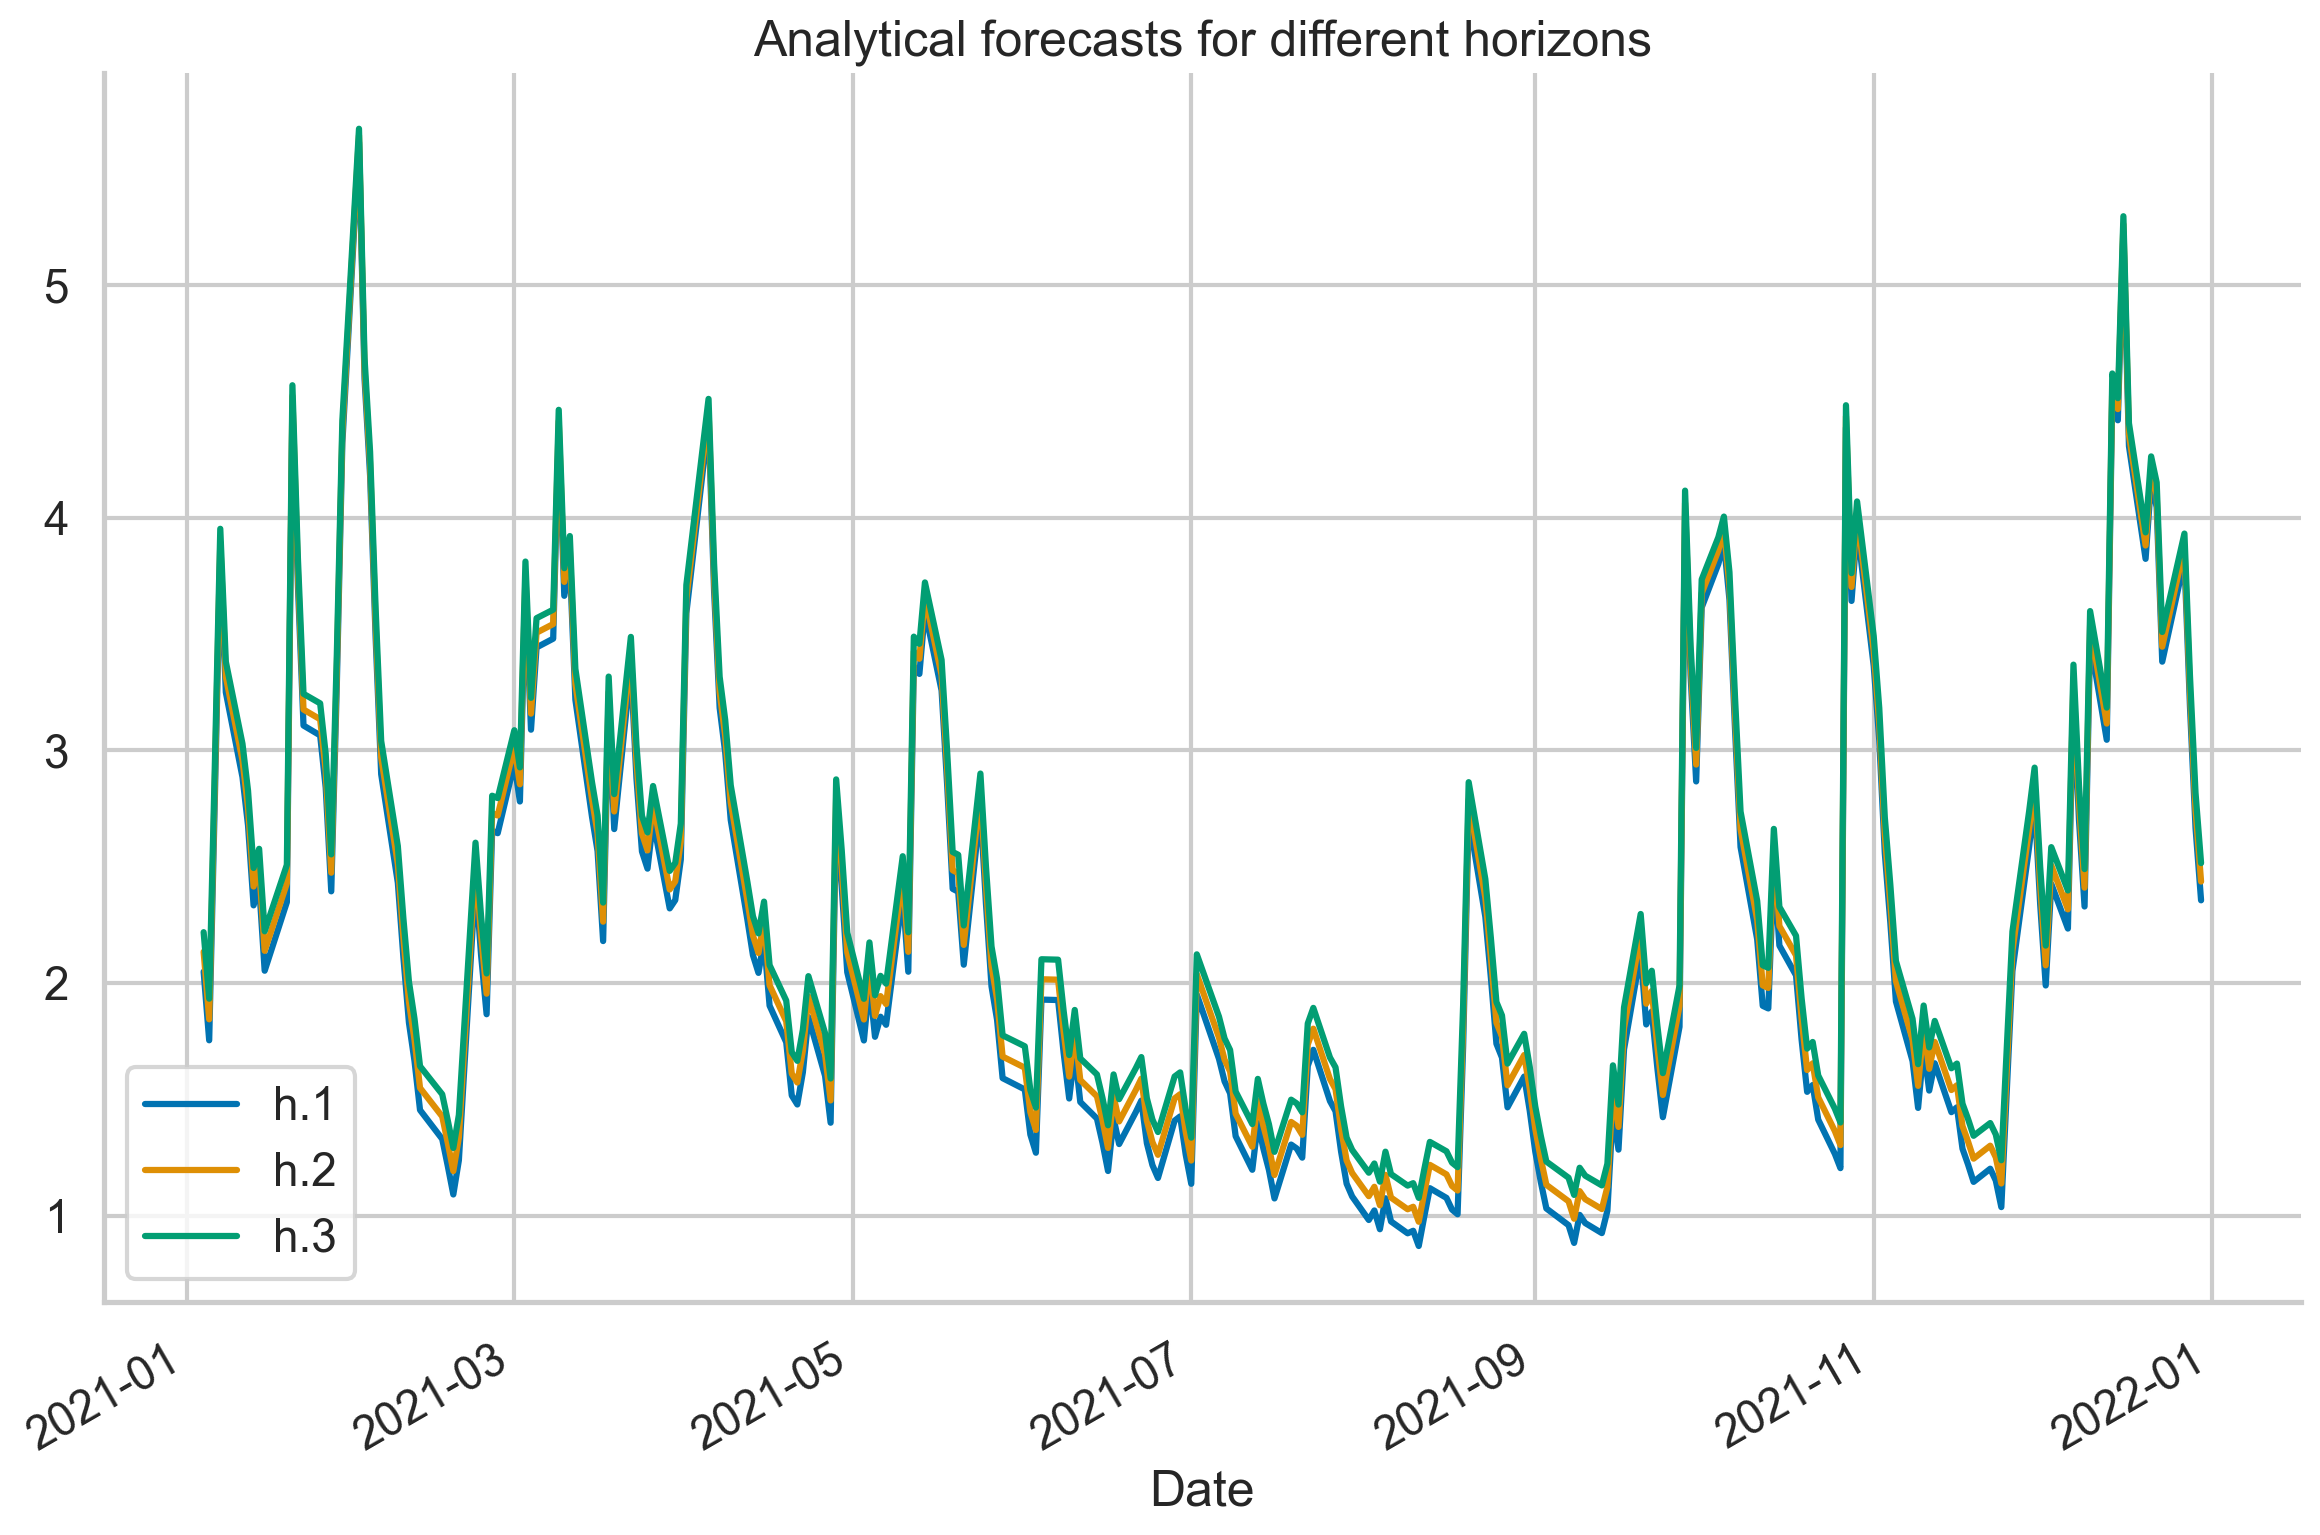

In [21]:
forecasts_analytical = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             reindex=False)
forecasts_analytical.variance.plot(
    title="Analytical forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_4", dpi=200)

In [22]:
forecasts_analytical.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048960,2.134418,2.218519
2021-01-05,1.754030,1.844165,1.932870
2021-01-06,2.770916,2.844923,2.917756
2021-01-07,3.838411,3.895486,3.951657
2021-01-08,3.248864,3.315290,3.380662
...,...,...,...
2021-12-23,3.380794,3.445128,3.508441
2021-12-27,3.817192,3.874604,3.931105
2021-12-28,3.185614,3.253043,3.319403


6. Create and inspect the simulation forecasts:

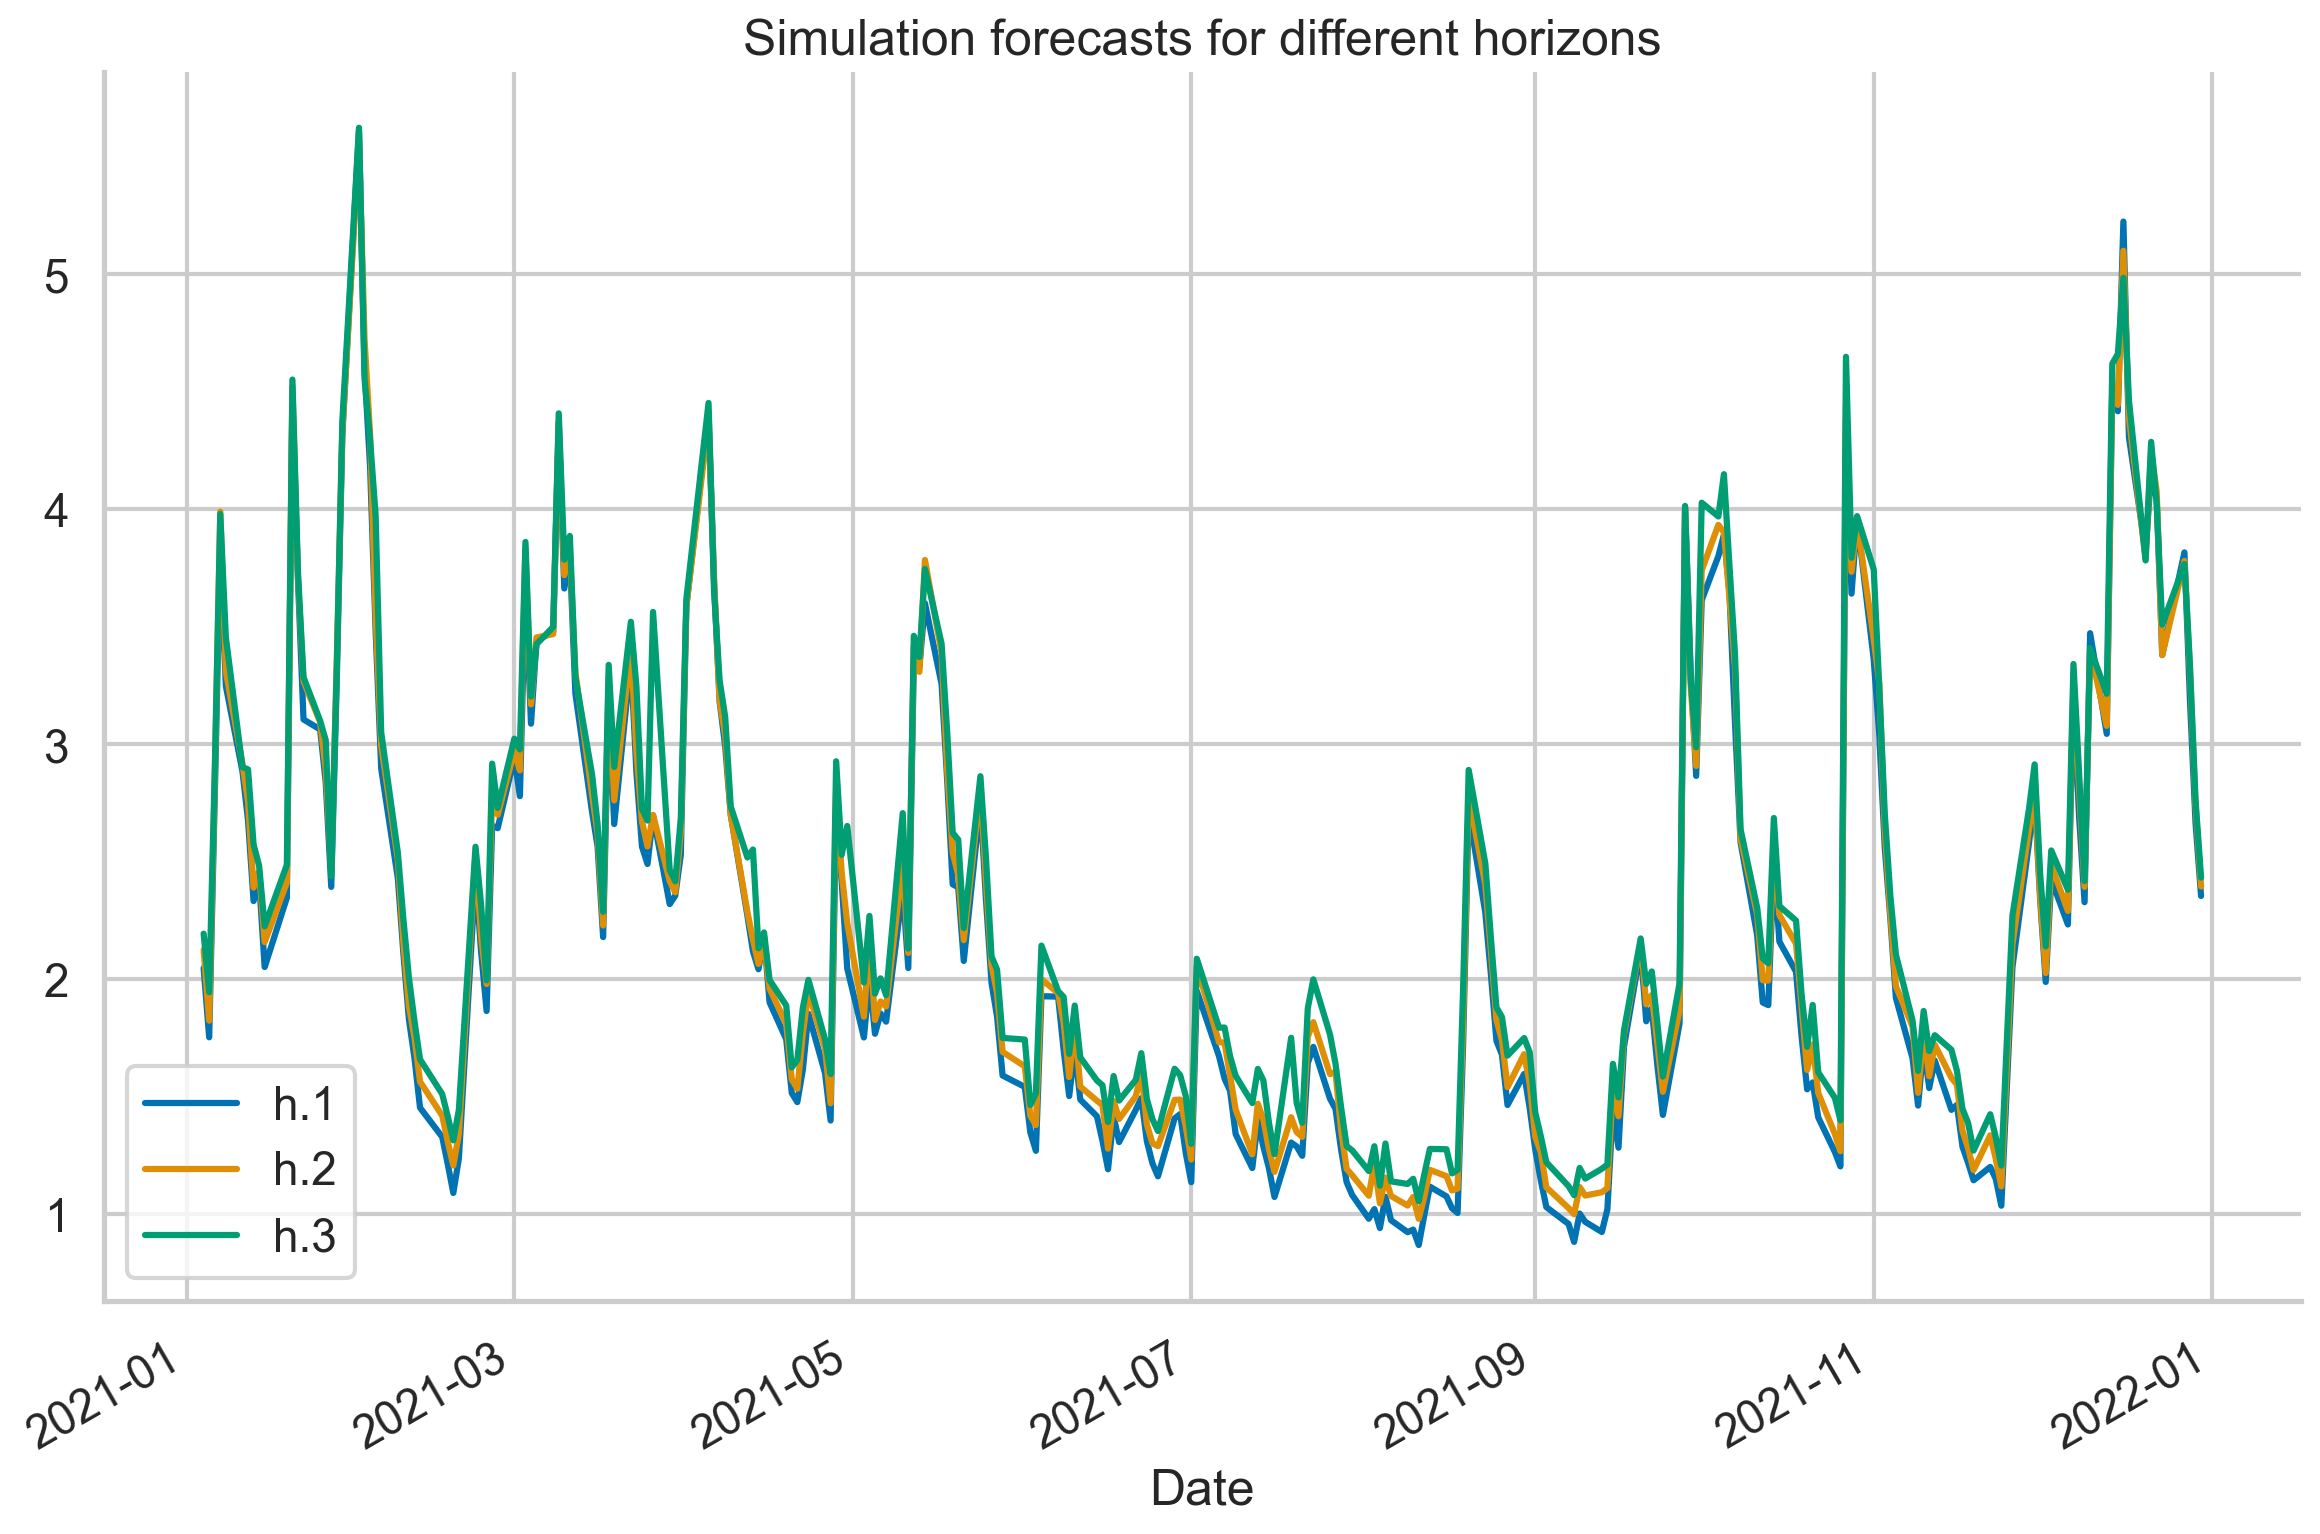

In [23]:
forecasts_simulation = fitted_model.forecast(horizon=3, 
                                             start=SPLIT_DATE,
                                             method="simulation",
                                             reindex=False)
forecasts_simulation.variance.plot(
    title="Simulation forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_6", dpi=200)

In [24]:
forecasts_simulation.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048960,2.126331,2.195004
2021-01-05,1.754030,1.824716,1.945858
2021-01-06,2.770916,2.838535,2.886087
2021-01-07,3.838411,3.990626,3.980477
2021-01-08,3.248864,3.312210,3.456184
...,...,...,...
2021-12-23,3.380794,3.380094,3.509829
2021-12-27,3.817192,3.780882,3.767885
2021-12-28,3.185614,3.313003,3.336002


7. Create and inspect the bootstrap forecasts:

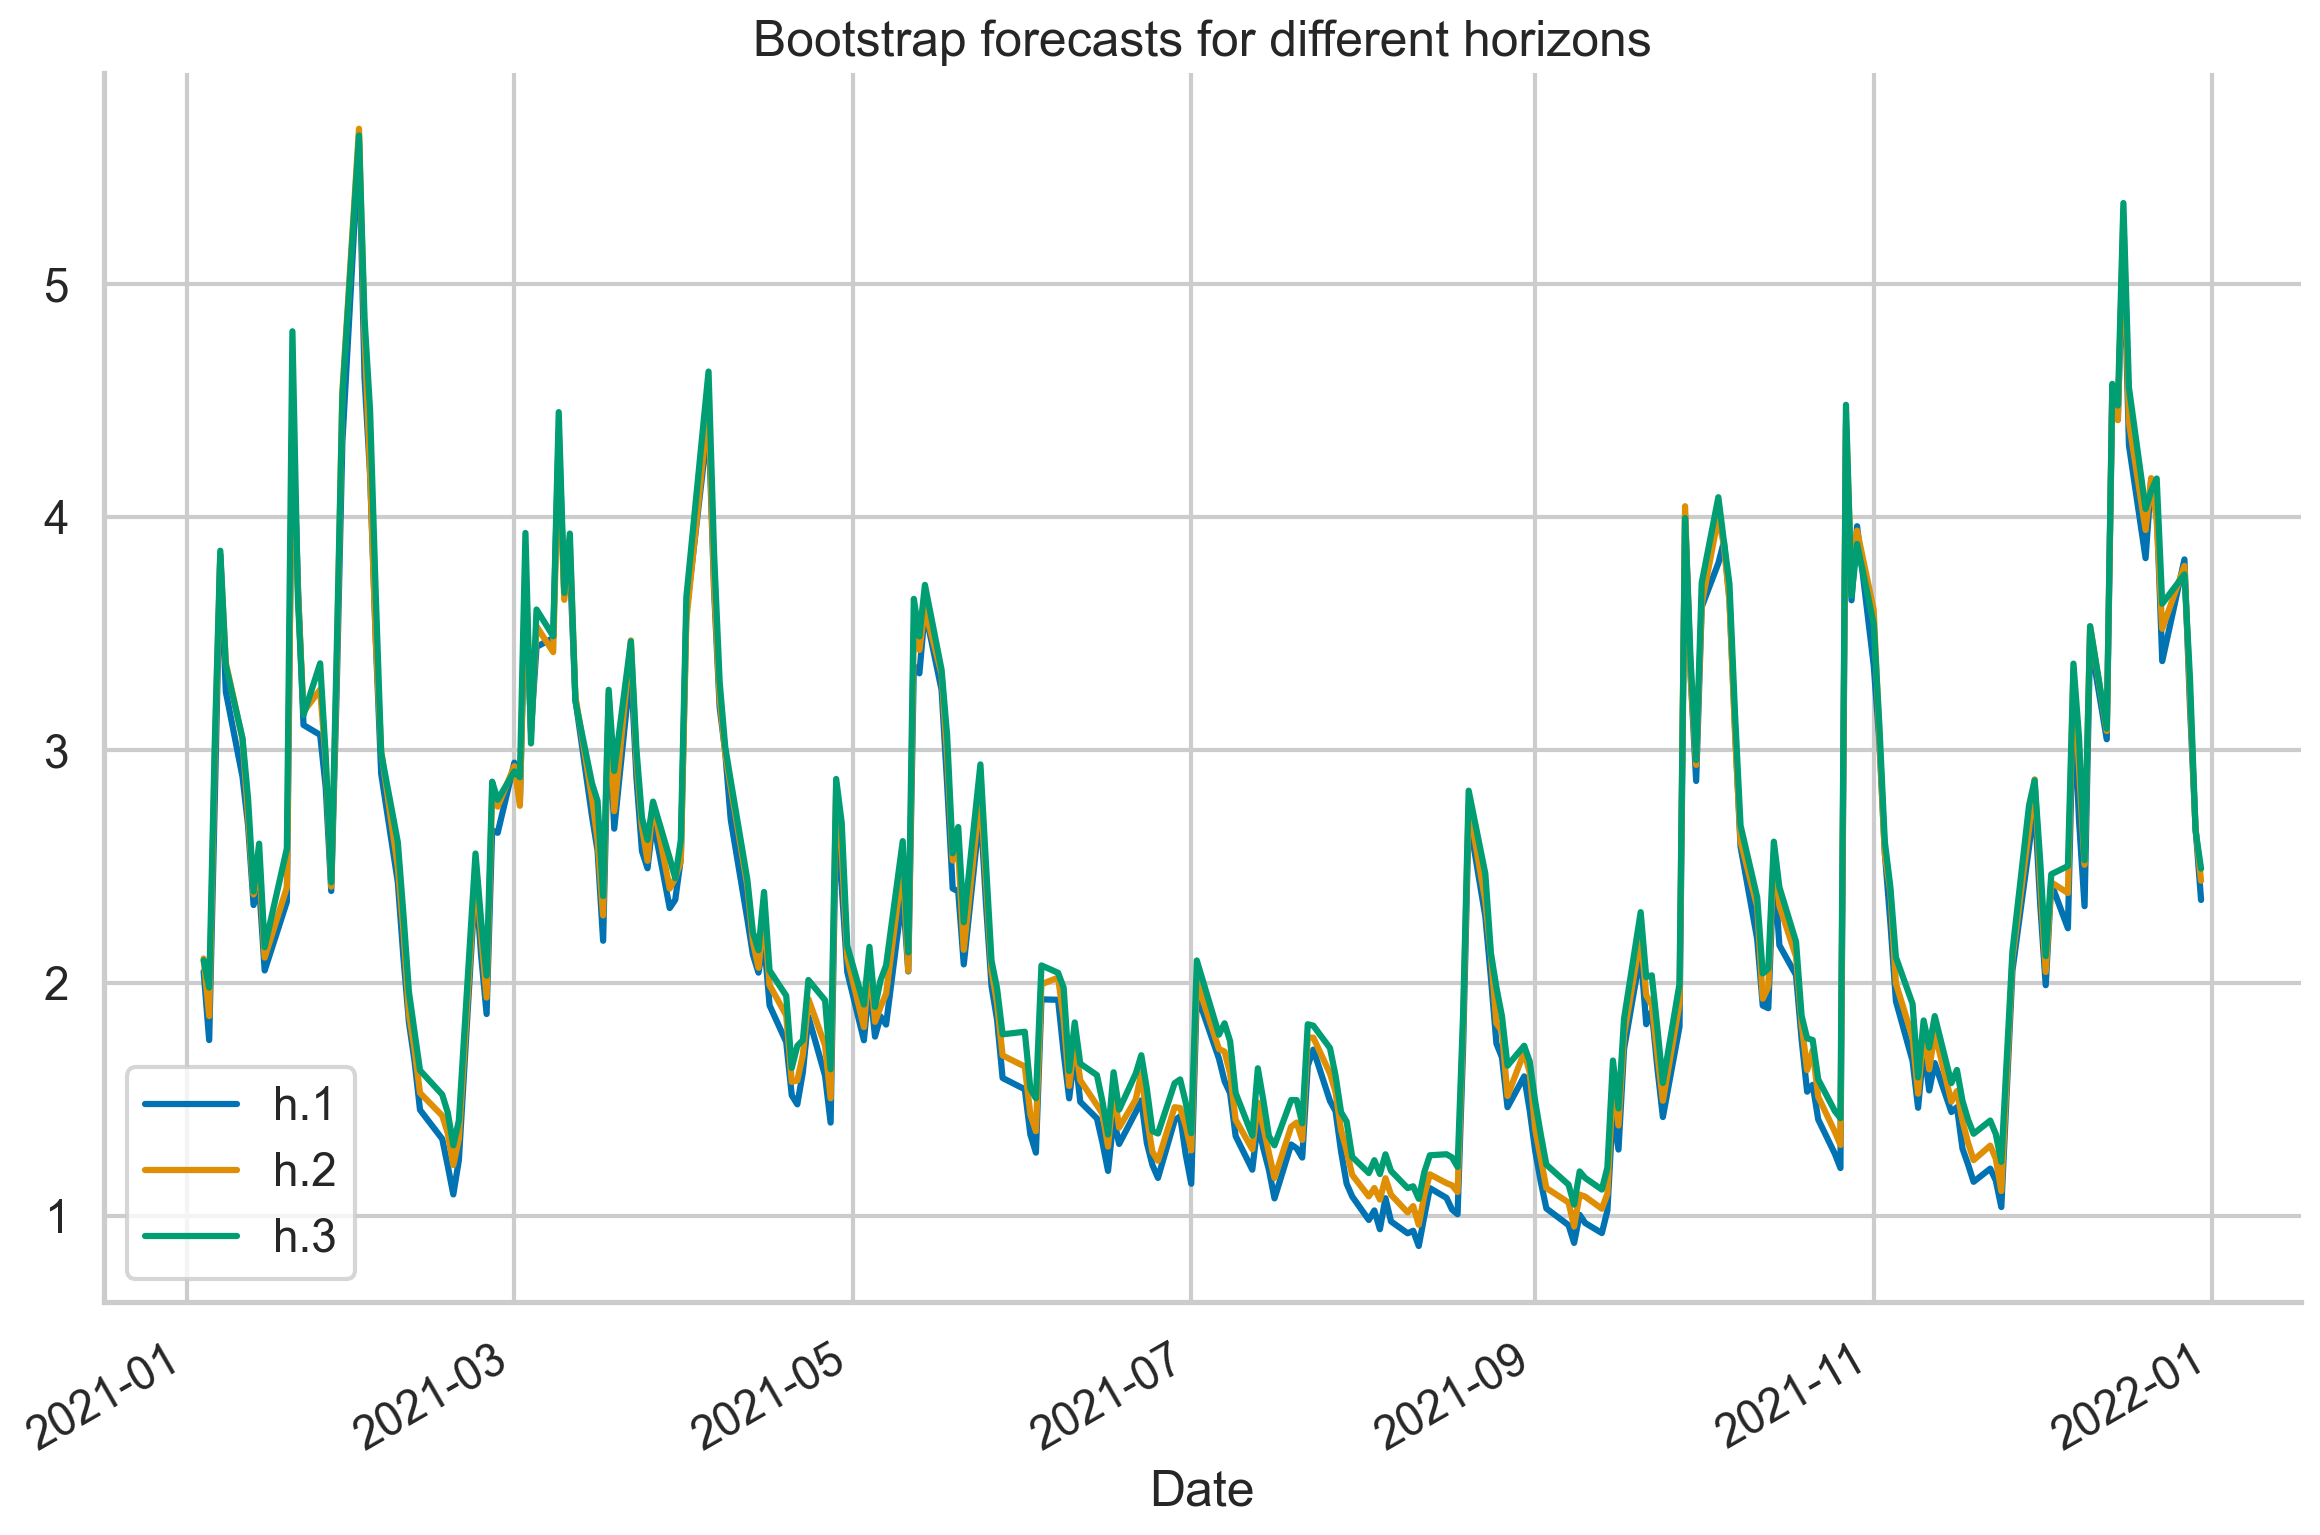

In [25]:
forecasts_bootstrap = fitted_model.forecast(horizon=3, 
                                            start=SPLIT_DATE,
                                            method="bootstrap",
                                            reindex=False)
forecasts_bootstrap.variance.plot(
    title="Bootstrap forecasts for different horizons"
)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_7", dpi=200)

In [26]:
forecasts_bootstrap.variance

,h.1,h.2,h.3
Date,,,
2021-01-04,2.048960,2.103880,2.096568
2021-01-05,1.754030,1.856933,1.979391
2021-01-06,2.770916,2.958708,3.023127
2021-01-07,3.838411,3.834688,3.854477
2021-01-08,3.248864,3.373404,3.362345
...,...,...,...
2021-12-23,3.380794,3.519250,3.627018
2021-12-27,3.817192,3.789476,3.752893
2021-12-28,3.185614,3.238761,3.308643


### There's more

1. Import the libraries:

In [27]:
import numpy as np

2. Estimate the volatility forecasts for 2020 using the analytic and bootstrap approaches:

In [28]:
# define the forecast horizon
FCST_HORIZON = 10

vol_analytic = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          reindex=False)
    .residual_variance.loc["2020"]
    .apply(np.sqrt)
)

vol_bootstrap = (
    fitted_model.forecast(horizon=FCST_HORIZON, 
                          start=datetime(2020, 1, 1),
                          method="bootstrap",
                          reindex=False)
    .residual_variance.loc["2020"]
    .apply(np.sqrt)
)


3. Get the conditional volatility for 2020:

In [29]:
vol = fitted_model.conditional_volatility["2020"]

4. Create the hedgehog plot:

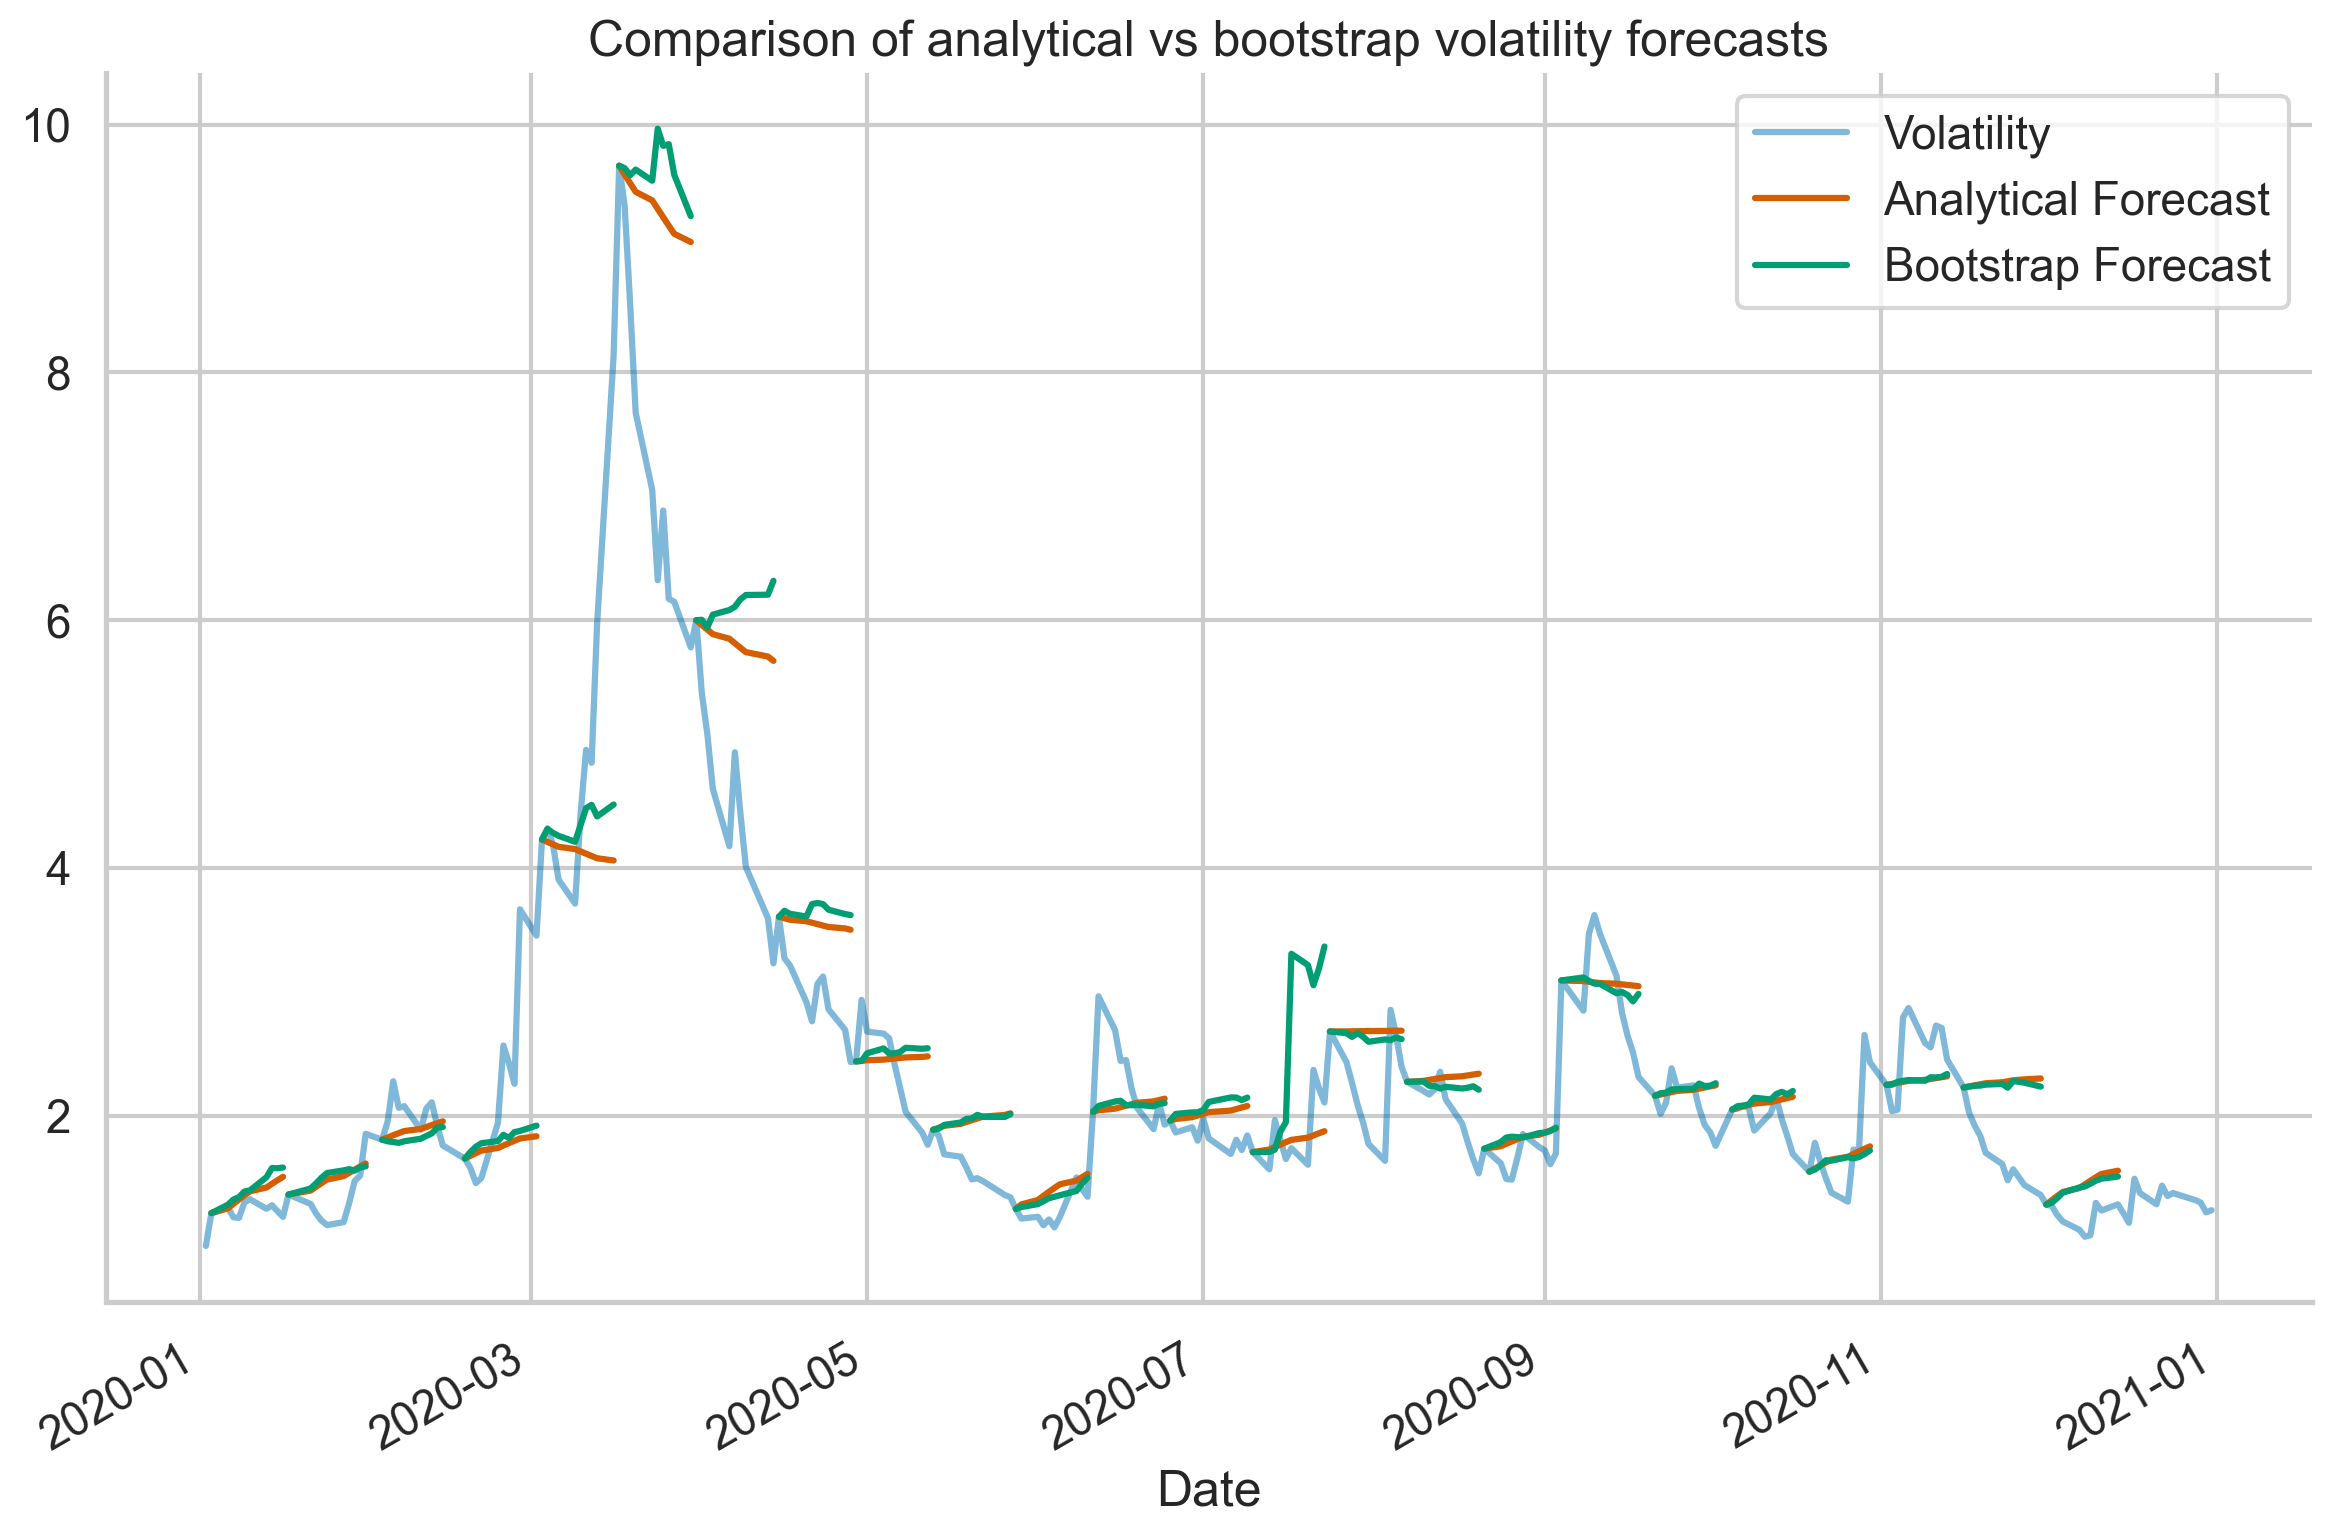

In [30]:
ax = vol.plot(
    title="Comparison of analytical vs bootstrap volatility forecasts",
    alpha=0.5
)
ind = vol.index

for i in range(0, 240, 10):
    vol_a = vol_analytic.iloc[i]
    vol_b = vol_bootstrap.iloc[i]
    start_loc = ind.get_loc(vol_a.name)
    new_ind = ind[(start_loc+1):(start_loc+FCST_HORIZON+1)]
    vol_a.index = new_ind
    vol_b.index = new_ind
    ax.plot(vol_a, color="r")
    ax.plot(vol_b, color="g")

labels = ["Volatility", "Analytical Forecast", "Bootstrap Forecast"]
legend = ax.legend(labels)

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_8", dpi=200)

## 9.4 Multivariate volatility forecasting with the CCC-GARCH model

### How to do it...

1. Import the libraries:

In [31]:
import pandas as pd
import numpy as np
import yfinance as yf
from arch import arch_model

2. Specify the risky asset and the time horizon:

In [32]:
RISKY_ASSETS = ["GOOG", "MSFT", "AAPL"]
START_DATE = "2015-01-01"
END_DATE = "2021-12-31"

3. Download data from Yahoo Finance:

In [33]:
df = yf.download(RISKY_ASSETS,
                 start=START_DATE,
                 end=END_DATE)

print(f"Downloaded {df.shape[0]} rows of data.")

[*********************100%%**********************]  3 of 3 completed

Downloaded 1762 rows of data.


4. Calculate daily returns:

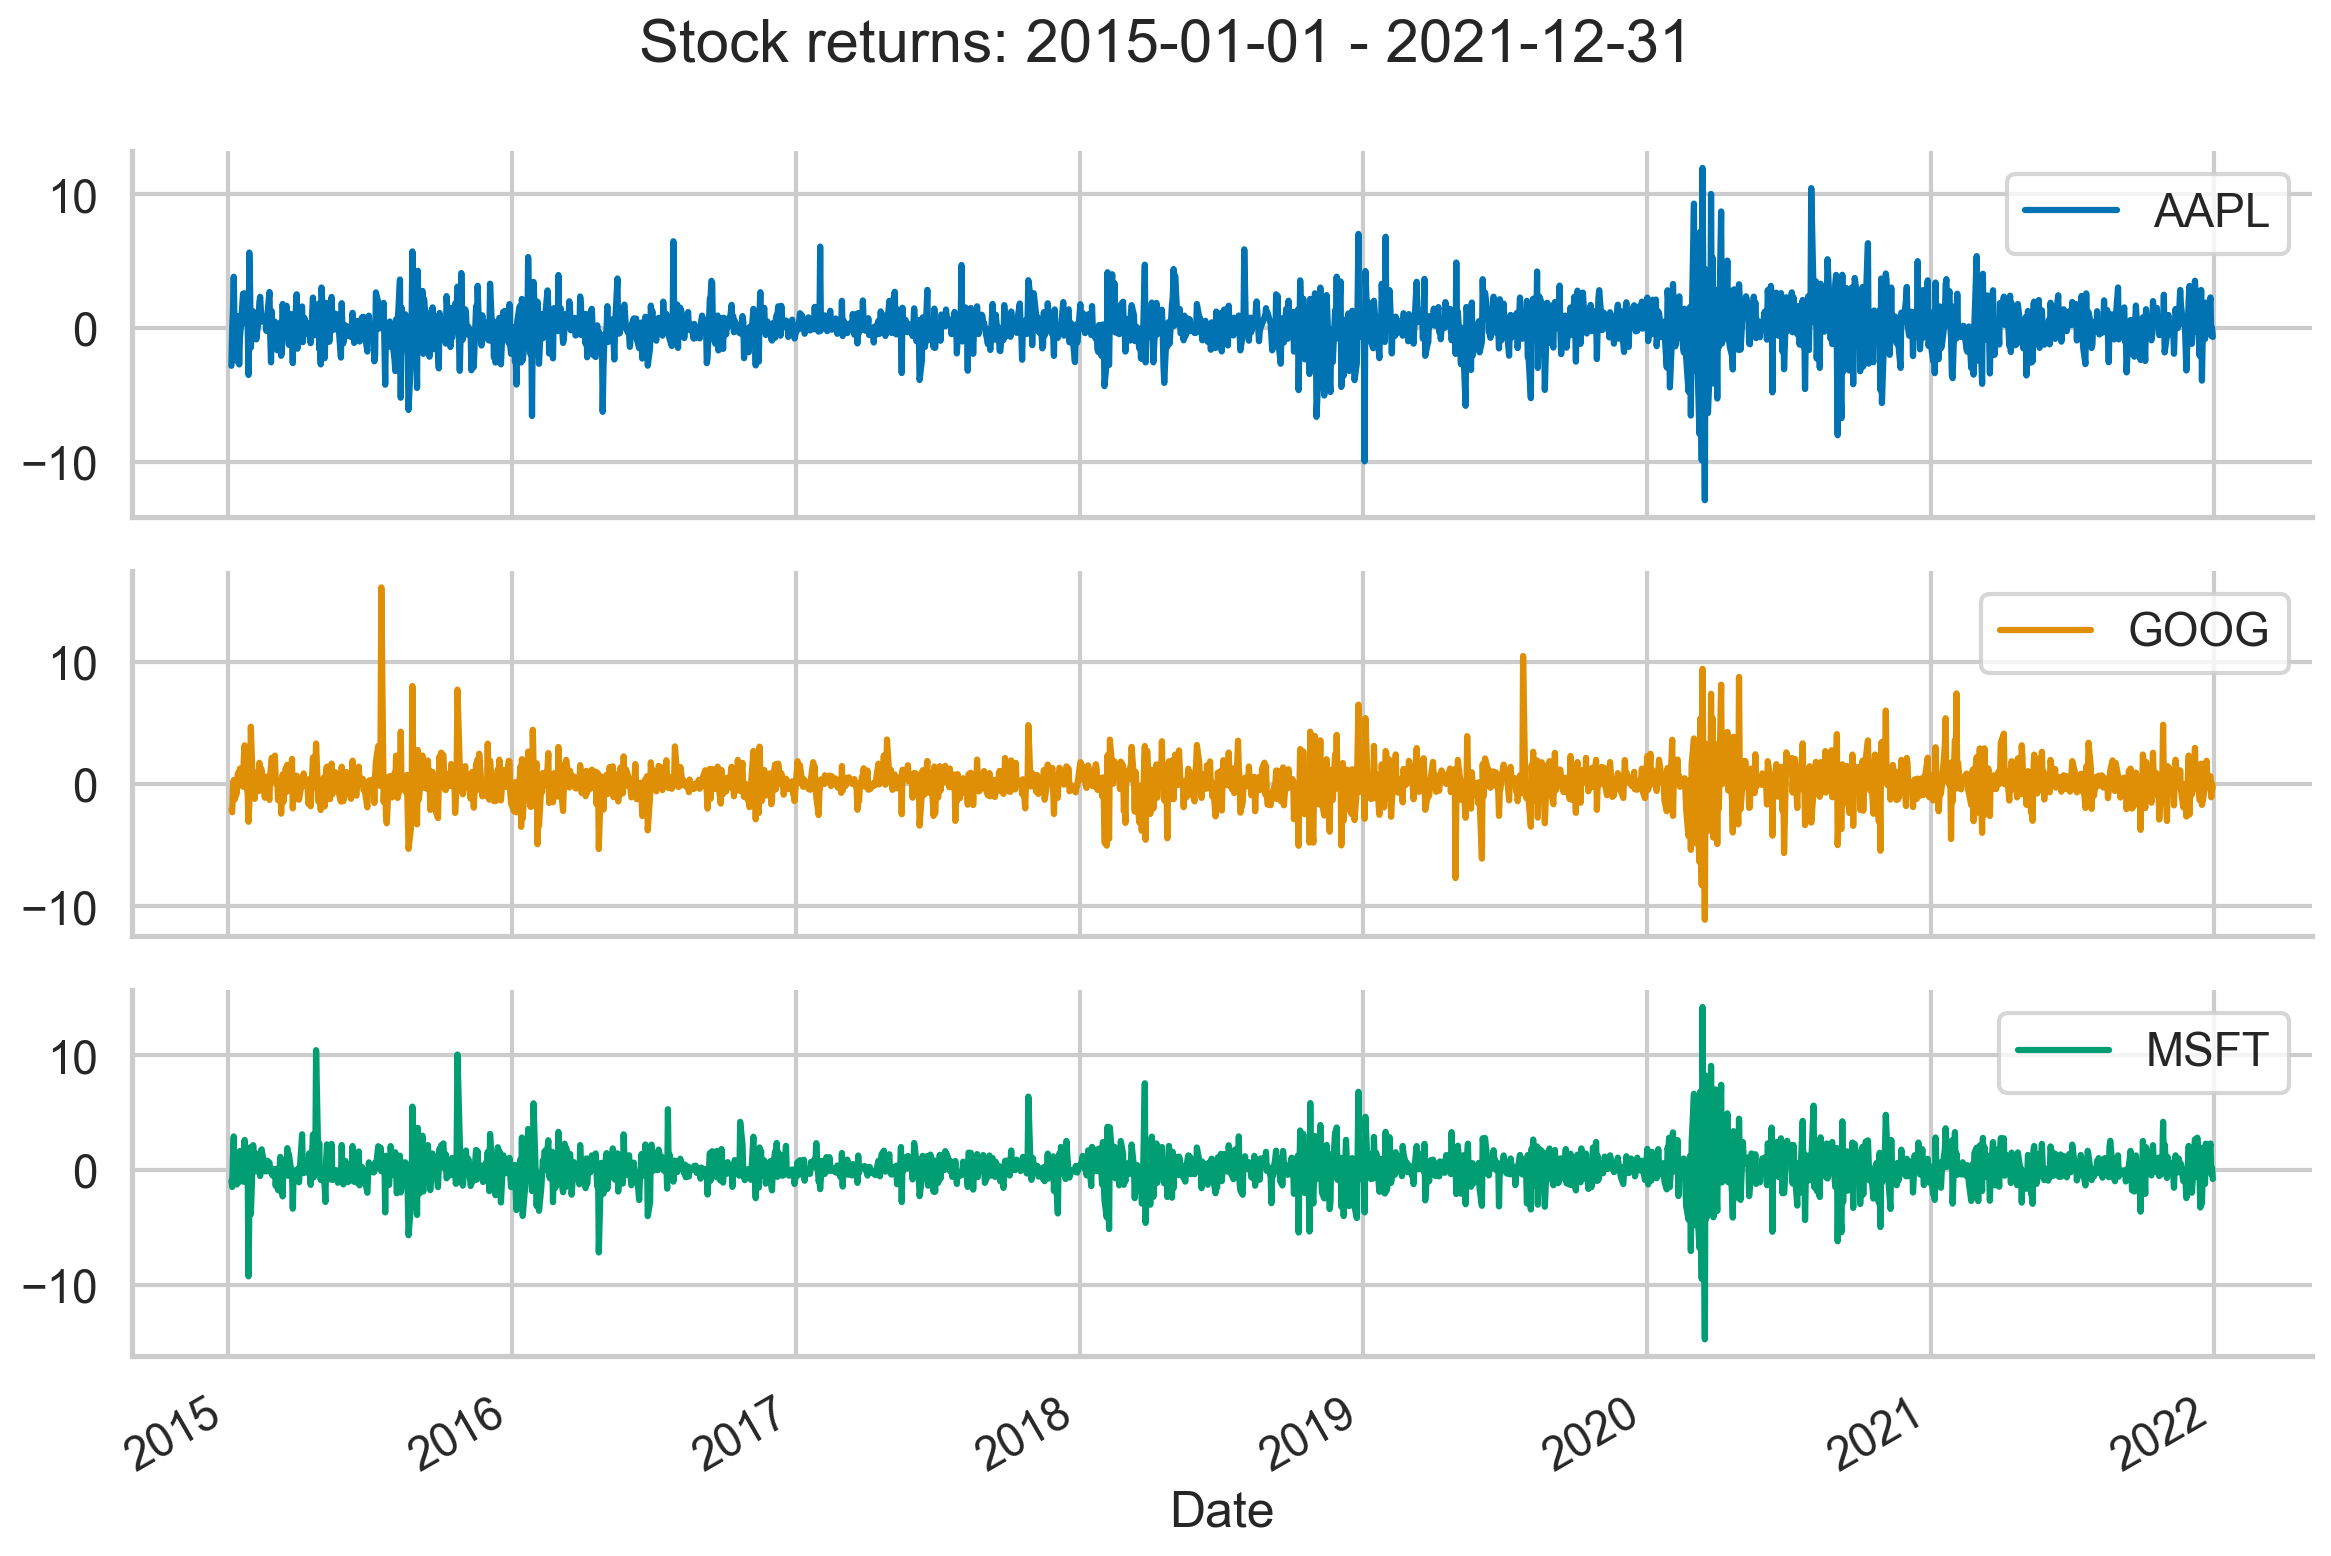

In [34]:
returns = 100 * df["Adj Close"].pct_change().dropna()
returns.plot(subplots=True, 
             title=f"Stock returns: {START_DATE} - {END_DATE}")

sns.despine()
plt.tight_layout()
# plt.savefig("images/figure_9_9", dpi=200)

5. Define lists for storing objects:

In [35]:
coeffs = []
cond_vol = []
std_resids = []
models = []

6. Estimate the univariate GARCH models:

In [36]:
for asset in returns.columns:
    # specify and fit the model
    model = arch_model(returns[asset], mean="Constant", 
                       vol="GARCH", p=1, q=1)
    model = model.fit(update_freq=0, disp="off");
    
    # store results in the lists 
    coeffs.append(model.params)
    cond_vol.append(model.conditional_volatility)
    std_resids.append(model.std_resid)
    models.append(model)

7. Store the results in DataFrames:

In [37]:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = (
    pd.DataFrame(cond_vol)
    .transpose()
    .set_axis(returns.columns,
              axis="columns")
)
std_resids_df = (
    pd.DataFrame(std_resids)
    .transpose()
    .set_axis(returns.columns, 
              axis="columns")
)

In [38]:
coeffs_df

,mu,omega,alpha[1],beta[1]
Ticker,,,,
AAPL,0.189583,0.176259,0.134657,0.811613
GOOG,0.125469,0.305893,0.183854,0.715030
MSFT,0.149252,0.267585,0.213112,0.700490


8. Calculate the constant conditional correlation matrix (R):

In [39]:
R = (
    std_resids_df
    .transpose()
    .dot(std_resids_df)
    .div(len(std_resids_df))
)

9. Calculate the 1-step ahead forecast of the conditional covariance matrix :

In [40]:
# define objects
diag = []
D = np.zeros((len(RISKY_ASSETS), len(RISKY_ASSETS)))

# populate the list with conditional variances
for model in models:
    diag.append(model.forecast(horizon=1).variance.iloc[-1, 0])
# take the square root to obtain volatility from variance
diag = np.sqrt(diag)
# fill the diagonal of D with values from diag
np.fill_diagonal(D, diag)

# calculate the conditional covariance matrix
H = np.matmul(np.matmul(D, R.values), D)

In [41]:
H

array([[2.39811731, 1.00565358, 1.19870675],
       [1.00565358, 1.5151801 , 1.12098399],
       [1.19870675, 1.12098399, 1.87603745]])